# Telecom Churn Case Study

Submitted by
- Mansi Gupta
- Parijaat Sunil
- Venkata Rama Krishna Kuruva

## 1. Initializing Python Libraries

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# importing machine learning libraries and methods
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_curve,roc_auc_score, classification_report

from imblearn.over_sampling import RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler, SMOTE,ADASYN

from imblearn.combine import SMOTETomek

In [2]:
# Setting pandas to display maximum number of columns
pd.set_option('display.max_columns', None)

## 2. Importing and analyzing the dataframe

In [3]:
# Importing the Telecom Churn data file into a pandas dataframe
data = pd.read_csv("telecom_churn_data.csv")


In [4]:
# Checking the top 5 rows of the dataframe
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [5]:
# Checking the shape of the dataframe
data.shape

(99999, 226)

In [6]:
# Checking info of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


Inferences:
- There are a 226 columns and 99999 rows in the data

## 3. Cleaning the dataframe

### a. Dropping columns with unique identifiers and single values

In [7]:
# Creating a list of all columns with unique identifiers and single values in the dataframe
uniq_cols = [x for x in data.columns if data[x].nunique() in (99999,1)]
uniq_cols

['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_t2c_mou_9',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'std_ic_t2o_mou_9']

In [8]:
# Dropping the columsn in the above list
data.drop(uniq_cols, axis =1, inplace=True)
data.shape

(99999, 209)

The columns with unique and single values have been dropped

### b. Dropping columns with a high number of missing values

In [9]:
# Finding the percentage of missing data in the dataframe
null_p = data.isnull().sum() / len(data) * 100
null_p

arpu_6         0.000000
arpu_7         0.000000
arpu_8         0.000000
arpu_9         0.000000
onnet_mou_6    3.937039
                 ...   
aon            0.000000
aug_vbc_3g     0.000000
jul_vbc_3g     0.000000
jun_vbc_3g     0.000000
sep_vbc_3g     0.000000
Length: 209, dtype: float64

We can drop columns with more than 40% missing data

In [10]:
# Finding columns with more than 40% missin data
drop_null_p = null_p[null_p>40]
drop_null_p

date_of_last_rech_data_6    74.846748
date_of_last_rech_data_7    74.428744
date_of_last_rech_data_8    73.660737
date_of_last_rech_data_9    74.077741
total_rech_data_6           74.846748
total_rech_data_7           74.428744
total_rech_data_8           73.660737
total_rech_data_9           74.077741
max_rech_data_6             74.846748
max_rech_data_7             74.428744
max_rech_data_8             73.660737
max_rech_data_9             74.077741
count_rech_2g_6             74.846748
count_rech_2g_7             74.428744
count_rech_2g_8             73.660737
count_rech_2g_9             74.077741
count_rech_3g_6             74.846748
count_rech_3g_7             74.428744
count_rech_3g_8             73.660737
count_rech_3g_9             74.077741
av_rech_amt_data_6          74.846748
av_rech_amt_data_7          74.428744
av_rech_amt_data_8          73.660737
av_rech_amt_data_9          74.077741
arpu_3g_6                   74.846748
arpu_3g_7                   74.428744
arpu_3g_8   

In [11]:
# Finding the total number of columns with more than 40% missing data
len(drop_null_p)

40

We see a total of 40 columns having more than 40% missing data. We can drop these columns from our dataframe.

In [12]:
# Dropping columns with more than 40% missing data
data.drop(drop_null_p.index, axis = 1, inplace = True)

In [13]:
# Checking the info of the dataframe after dropping columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 169 entries, arpu_6 to sep_vbc_3g
dtypes: float64(132), int64(33), object(4)
memory usage: 128.9+ MB


In [14]:
# Checking the remaining columns
data.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,2,6,362,252,252,0,252,252,252,0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,252,252,252,0,30.13,1.32,5.75,0.0,83.57,150.76,109.61,0.00,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,968,30.4,0.0,101.20,3.58
1,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.0,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,4.11,0.00,0.00,0.00,0.46,0.13,0.00,0.00,0.00,0.00,0.0,0.23,4.58,0.13,0.00,0.0,0.0,0.0,0.0,4.68,23.43,12.76,0.00,0.00,0.0,0.0,0.0,40.31,178.53,312.44,72.11,1.61,29.91,29.23,116.09,17.48,65.38,375.58,56.93,0.00,8.93,3.61,0.00,19.09,104.23,408.43,173.03,0.00,0.00,2.35,0.00,5.90,0.00,12.49,15.01,0.00,0.00,0.00,0.00,5.90,0.00,14.84,15.01,26.83,104.23,423.28,188.04,0.00,0.0,0.0,0.00,1.83,0.00,0.0,0.00,0.00,0.00,0.0,0.00,4,9,11,5,74,384,283,121,44,154,65,50,6/29/2014,7/31/2014,8/28/2014,9/30/2014,44,23,30,0,0.00,108.07,365.47,0.0,0.00,0.00,0.00,0.00,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1006,0.0,0.0

### c. Handling columns with date values

We can drop columns with date values as we will capture churn based on already available columns from September month data

In [15]:
# Finding all columns with data data
date_col = [col for col in data.columns if 'date' in col]
date_col

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9']

In [16]:
# Dropping all columns containing date values
data.drop(date_col, axis = 1, inplace = True)
data.shape

(99999, 165)

### d. Dropping all rows with duplicate data

In [17]:
# Dropping rows with duplicate data
data.drop_duplicates()
data.shape

(99999, 165)

There were no duplicate rows in the data

### e. Finding the high value customers and dropping other rows

As per problem statement, the high value customers are defined as the top 70 percentile of customers by recharge amounts in June and July months

In [18]:
# Creating a new column to find mean of recharge amounts in June and July
data['total_rchg_6_7'] = (data['total_rech_amt_6'] + data['total_rech_amt_7'])/2
data['total_rchg_6_7']

0        307.0
1        229.0
2        241.5
3        270.0
4        273.0
         ...  
99994     85.0
99995    110.0
99996     59.5
99997    369.5
99998    355.0
Name: total_rchg_6_7, Length: 99999, dtype: float64

In [19]:
# Calculating the 70th percentile of this newly added column
percentile_70 = np.percentile(data['total_rchg_6_7'],70)
percentile_70

368.5

In [20]:
# Finding the high value customers
data['high_value_customer'] = data['total_rchg_6_7'][data['total_rchg_6_7'] >= percentile_70]
data['high_value_customer'].unique()

array([   nan, 1185. ,  519. , ..., 3925. , 2915.5, 1878. ])

In [21]:
# Finding the subset of non null values from high_value_customer column
data_df = data.dropna(subset = ['high_value_customer'])
data_df.shape

(30011, 167)

In [22]:
# Dropping the created column for recharge amount in June and July
data_df.drop('total_rchg_6_7', axis = 1, inplace = True)
data_df.drop('high_value_customer', axis = 1, inplace = True)

In [23]:
data_df.shape

(30011, 165)

We now have our dataset with high value customers only

### f. Creating the churn column and dropping columns for September

In [24]:
# Creating a custom function to check if incoming or outgoing for September is 0
def compare_for_churn(df):
    if (df['total_og_mou_9'] == 0 and df['total_ic_mou_9'] == 0) and (df['vol_2g_mb_9']==0 and df['vol_3g_mb_9']==0):
        return 1
    else:
        return 0

# Applying the function to our dataframe
data_df['churn'] = data_df.apply(compare_for_churn, axis = 1)
data_df.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
7,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,NaN,453.43,567.16,325.91,NaN,16.23,33.49,31.64,NaN,23.74,12.59,38.06,NaN,51.39,31.38,40.28,NaN,308.63,447.38,162.28,NaN,62.13,55.14,53.23,NaN,0.0,0.0,0.00,NaN,422.16,533.91,255.79,NaN,4.30,23.29,12.01,NaN,49.89,31.76,49.14,NaN,6.66,20.08,16.68,NaN,60.86,75.14,77.84,NaN,0.0,0.18,10.01,NaN,4.50,0.00,6.50,NaN,0.00,0.0,0.0,NaN,487.53,609.24,350.16,0.00,58.14,32.26,27.31,NaN,217.56,221.49,121.19,NaN,152.16,101.46,39.53,NaN,427.88,355.23,188.04,NaN,36.89,11.83,30.39,NaN,91.44,126.99,141.33,NaN,52.19,34.24,22.21,NaN,180.54,173.08,193.94,NaN,626.46,558.04,428.74,0.00,0.21,0.0,0.0,NaN,2.06,14.53,31.59,NaN,15.74,15.19,15.14,NaN,5,5,7,3,1580,790,3638,0,1580,790,1580,0,0,0,779,0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.0,1
8,378.721,492.223,137.362,166.787,413.69,351.03,35.08,33.46,94.66,80.63,136.48,108.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,26.13,80.96,70.58,50.54,34.58,0.00,0.00,0.00,0.00,0.0,0.0,7.15,0.0,378.09,288.18,63.04,60.71,116.56,133.43,22.58,7.33,13.69,10.04,75.69,74.13,0.00,0.00,0.00,0.00,130.26,143.48,98.28,81.46,0.0,0.00,0.00,0.0,0.00,0.00,10.23,0.00,0.00,0.0,0.0,0.0,508.36,431.66,171.56,142.18,23.84,9.84,0.31,4.03,57.58,13.98,15.48,17.34,0.00,0.00,0.00,0.00,81.43,23.83,15.79,21.38,0.00,0.58,0.10,0.00,22.43,4.08,0.65,13.53,0.00,0.00,0.00,0.0,22.43,4.66,0.75,13.53,103.86,28.49,16.54,34.91,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,15,437,601,120,186,90,154,30,36,50,0,10,0,0.0,356.0,0.03,0.0,0.0,750.95,11.94,0.0,0,1,0,0,0,1,3,0,0,0,0,0,0,0,0,0,

In [25]:
# Creating a list of all columns with data for September
col_9 = [col for col in data_df.columns if ('_9' in col) or ('sep' in col)]
col_9

['arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'last_day_rch_amt_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9',
 'sep_vbc_3g']

In [26]:
# Dropping all columns with data from September
data_df.drop(col_9, axis=1, inplace=True)

In [27]:
data_df.shape

(30011, 125)

In [28]:
# Checking the data imbalance
data_df['churn'].value_counts(normalize = True)*100

churn
0    91.359835
1     8.640165
Name: proportion, dtype: float64

There is a large data imbalance in the dataset with only 8.6% of customers who have churned. We need to handle this imbalance

### g. Assessing other columns with missing values

In [29]:
# Checking the null percentage for columns with any missing values
null_p = data_df.isnull().sum() / len(data) * 100
null_p[null_p>0].sort_values(ascending=False)

ic_others_8         0.938009
loc_og_t2m_mou_8    0.938009
std_og_mou_8        0.938009
spl_og_mou_8        0.938009
std_og_t2f_mou_8    0.938009
                      ...   
std_og_t2f_mou_7    0.303003
og_others_7         0.303003
std_og_mou_7        0.303003
spl_og_mou_7        0.303003
isd_og_mou_7        0.303003
Length: 81, dtype: float64

In [30]:
# Checking the null values where churn is 1
null_ch = data_df[data_df.churn==1].isnull().sum() / len(data) * 100
null_ch[null_ch>0].sort_values(ascending=False)

ic_others_8         0.736007
loc_og_t2m_mou_8    0.736007
std_og_mou_8        0.736007
spl_og_mou_8        0.736007
std_og_t2f_mou_8    0.736007
                      ...   
loc_ic_t2t_mou_6    0.106001
std_og_mou_6        0.106001
og_others_6         0.106001
isd_og_mou_6        0.106001
onnet_mou_6         0.106001
Length: 81, dtype: float64

As we cannot lose any columns with churn as 1, we can fill the above missing values by 0

In [31]:
# Filling all missing values with 0 where churn is 1

data_df.loc[data_df.churn==1,:]=data_df.loc[data_df.churn==1,:].fillna(0)

# Checking the null values where churn is 1 again
null_ch = data_df[data_df.churn==1].isnull().sum() / len(data) * 100
null_ch[null_ch>0].sort_values(ascending=False)

Series([], dtype: float64)

In [32]:
# Checking the null percentage for columns with any missing values again
null_p = data_df.isnull().sum() / len(data) * 100
null_p[null_p>0].sort_values(ascending=False)

onnet_mou_6         0.210002
std_ic_t2m_mou_6    0.210002
spl_og_mou_6        0.210002
std_og_mou_6        0.210002
og_others_6         0.210002
                      ...   
std_og_t2f_mou_7    0.144001
og_others_7         0.144001
std_og_mou_7        0.144001
spl_og_mou_7        0.144001
isd_og_mou_7        0.144001
Length: 81, dtype: float64

We can drop these rows as they are a very small fraction of the data, and this will also reduce imbalance

In [33]:
# Droppng remaining rows with missing values
data_df.dropna(inplace=True)

In [34]:
# Checking the null percentage for columns with any missing values again
null_p = data_df.isnull().sum() / len(data) * 100
null_p[null_p>0].sort_values(ascending=False)

Series([], dtype: float64)

In [35]:
data_df.shape

(29647, 125)

In [36]:
# Checking the data imbalance again
data_df['churn'].value_counts(normalize = True)*100

churn
0    91.253752
1     8.746248
Name: proportion, dtype: float64

### h. Dropping total columns for incoming, outgoing

If we analyze the data, we see that the total columns for example loc_og_mou, std_og_mou, total_og_mou, loc_ic_mou_6 etc. are not always correct. There are several places where the sum is wrong. We can drop these columns and create new total columns as derived variables


In [37]:
# Creating a list of all columns with total values
total_cols = ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','std_og_mou_6','std_og_mou_7','std_og_mou_8','total_og_mou_6','total_og_mou_7',
             'total_og_mou_8','loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','total_ic_mou_6',
             'total_ic_mou_7','total_ic_mou_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8']

# Dropping the above columns
data_df.drop(total_cols, axis=1, inplace=True)
data_df.shape

(29647, 101)

In [38]:
data_df.head()

,arpu_6,arpu_7,arpu_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
7,1069.180,1349.850,3171.480,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1
8,378.721,492.223,137.362,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0
13,492.846,205.671,593.260,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0
16,430.975,299.869,187.894,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.0,0.0,0.00,7.89,2.58,3.23,22.99,64.51,18.29,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.26,5.91,0.00,0.0,0.0,41.33,71.44,28.89,226.81,149.69,150.16,8.71,8.68,32.71,68.79,78.64,6.33,18.68,73.08,73.93,0.51,0.00,2.18,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.00,0.00,10,6,2,570,348,160,110,110,130,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,0
17,690.008,18.980,25.499,0.00,4.76,4.81,0.00,8.46,13.34,38.99,0.00,0.00,58.54,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1146.91,0.81,0.00,1.55,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2.58,0.00,0.00,0.93,0.0,0.0,34.54,0.00,0.00,47.41,2.31,0.00,0.00,0.00,0.00,8.63,0.00,0.00,1.28,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,2,4,816,0,30,110,0,30,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.00,0


## 4. Creating derived variables

We can now create the total rows for incoming and outgoing MOU categories. We will keep the T2C columns without adding them to the total rows as we expect to see higher calls to call centres in case of churn.

### a. Outgoing MOU for each month

In [39]:
# Creating a list of all columns to be added for each month except T2C Columns
og_mou_6 = ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6','isd_og_mou_6',
            'spl_og_mou_6','og_others_6']

og_mou_7 = ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7','isd_og_mou_7',
            'spl_og_mou_7','og_others_7']

og_mou_8 = ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8','isd_og_mou_8',
            'spl_og_mou_8','og_others_8']

# Creating a new sum columns for each month
data_df['total_og_mou_6']=data_df[og_mou_6].sum(axis=1)
data_df['total_og_mou_7']=data_df[og_mou_7].sum(axis=1)
data_df['total_og_mou_8']=data_df[og_mou_8].sum(axis=1)
data_df.head()

,arpu_6,arpu_7,arpu_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,total_og_mou_6,total_og_mou_7,total_og_mou_8
7,1069.180,1349.850,3171.480,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,487.50,609.21,350.13
8,378.721,492.223,137.362,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,508.34,431.64,171.53
13,492.846,205.671,593.260,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0,907.07,192.39,1015.22
16,430.975,299.869,187.894,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.0,0.0,0.00,7.89,2.58,3.23,22.99,64.51,18.29,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.26,5.91,0.00,0.0,0.0,41.33,71.44,28.89,226.81,149.69,150.16,8.71,8.68,32.71,68.79,78.64,6.33,18.68,73.08,73.93,0.51,0.00,2.18,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.00,0.00,10,6,2,570,348,160,110,110,130,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,0,346.78,285.98,233.35
17,690.008,18.980,25.499,0.00,4.76,4.81,0.00,8.46,13.34,38.99,0.00,0.00,58.54,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1146.91,0.81,0.00,1.55,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2.58,0.00,0.00,0.93,0.0,0.0,34.54,0.00,0.00,47.41,2.31,0.00,0.00,0.00,0.00,8.63,0.00,0.00,1.28,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,2,4,816,0,30,110,0,30,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.0

In [40]:
# Dropping the outgoing columns
data_df.drop(og_mou_6, axis=1, inplace=True)
data_df.drop(og_mou_7, axis=1, inplace=True)
data_df.drop(og_mou_8, axis=1, inplace=True)
data_df.shape

(29647, 77)

### b. Incoming MOU for each month

In [41]:
# Creating a list of all columns to be added for each month
ic_mou_6 = ['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','spl_ic_mou_6',
            'isd_ic_mou_6','ic_others_6']

ic_mou_7 = ['loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7','spl_ic_mou_7',
            'isd_ic_mou_7','ic_others_7']

ic_mou_8 = ['loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8','spl_ic_mou_8',
            'isd_ic_mou_8','ic_others_8']

# Creating a new sum columns for each month
data_df['total_ic_mou_6']=data_df[ic_mou_6].sum(axis=1)
data_df['total_ic_mou_7']=data_df[ic_mou_7].sum(axis=1)
data_df['total_ic_mou_8']=data_df[ic_mou_8].sum(axis=1)
data_df.head()

,arpu_6,arpu_7,arpu_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
7,1069.180,1349.850,3171.480,16.23,33.49,31.64,23.74,12.59,38.06,0.0,0.0,0.00,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,487.50,609.21,350.13,626.39,557.99,428.69
8,378.721,492.223,137.362,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,7.15,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,508.34,431.64,171.53,103.85,28.48,16.54
13,492.846,205.671,593.260,23.53,144.24,72.11,7.98,35.26,1.44,0.0,0.0,0.49,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0,907.07,192.39,1015.22,968.59,172.54,1144.48
16,430.975,299.869,187.894,0.00,2.83,0.00,0.00,17.74,0.00,0.0,0.0,0.00,41.33,71.44,28.89,226.81,149.69,150.16,8.71,8.68,32.71,68.79,78.64,6.33,18.68,73.08,73.93,0.51,0.00,2.18,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.00,0.00,10,6,2,570,348,160,110,110,130,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,0,346.78,285.98,233.35,364.83,381.53,294.43
17,690.008,18.980,25.499,0.00,4.76,4.81,0.00,8.46,13.34,0.0,0.0,0.00,34.54,0.00,0.00,47.41,2.31,0.00,0.00,0.00,0.00,8.63,0.00,0.00,1.28,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,2,4,816,0,30,110,0,30,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.00,0,1249.50,0.81,0.00,91.86,2.31,0.00


In [42]:
# Dropping the outgoing columns
data_df.drop(ic_mou_6, axis=1, inplace=True)
data_df.drop(ic_mou_7, axis=1, inplace=True)
data_df.drop(ic_mou_8, axis=1, inplace=True)
data_df.shape

(29647, 53)

### c. Creating combined data columns

In [43]:
# Adding the respective variables for 2G and 3G columns
data_df['data_6']=data_df.vol_2g_mb_6 + data_df.vol_3g_mb_6
data_df['data_7']=data_df.vol_2g_mb_7 + data_df.vol_3g_mb_7
data_df['data_8']=data_df.vol_2g_mb_8 + data_df.vol_3g_mb_8
data_df['monthly_6']=data_df.monthly_2g_6 + data_df.monthly_3g_6
data_df['monthly_7']=data_df.monthly_2g_7 + data_df.monthly_3g_7
data_df['monthly_8']=data_df.monthly_2g_8 + data_df.monthly_3g_8
data_df['sachet_6']=data_df.sachet_2g_6 + data_df.sachet_3g_6
data_df['sachet_7']=data_df.sachet_2g_7 + data_df.sachet_3g_7
data_df['sachet_8']=data_df.sachet_2g_8 + data_df.sachet_3g_8

# Dropping the 2G & 3G columns
data_df.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','monthly_2g_6','monthly_2g_7',
              'monthly_2g_8','monthly_3g_6','monthly_3g_7','monthly_3g_8','sachet_2g_6','sachet_2g_7','sachet_2g_8','sachet_3g_6',
              'sachet_3g_7','sachet_3g_8'], axis=1, inplace=True)

In [44]:
data_df.shape

(29647, 44)

### d. Creating variables to store the average values of good phase (June and July)

In [45]:
# creating column to store average arpu for 6 & 7 and dropping individual cols
data_df['arpu_avg_good'] = (data_df.arpu_6 + data_df.arpu_7)/2
data_df.drop(['arpu_6','arpu_7'], axis=1, inplace=True)

# creating column to store average roaming mou for 6 & 7 and dropping individual cols
data_df['roam_ic_avg_good'] = (data_df.roam_ic_mou_6 + data_df.roam_ic_mou_7)/2
data_df['roam_og_avg_good'] = (data_df.roam_og_mou_6 + data_df.roam_og_mou_7)/2
data_df.drop(['roam_og_mou_6','roam_og_mou_7','roam_ic_mou_6','roam_ic_mou_7'], axis=1, inplace=True)

# creating column to store average T2C mou for 6 & 7 and dropping individual cols
data_df['T2C_avg_good'] = (data_df.loc_og_t2c_mou_6 + data_df.loc_og_t2c_mou_7)/2
data_df.drop(['loc_og_t2c_mou_6','loc_og_t2c_mou_7'], axis=1, inplace=True)

# creating column to store average rech num for 6 & 7 and dropping individual cols
data_df['rech_num_avg_good'] = (data_df.total_rech_num_6 + data_df.total_rech_num_7)/2
data_df.drop(['total_rech_num_6','total_rech_num_7'], axis=1, inplace=True)

# creating column to store average rech amt for 6 & 7 and dropping individual cols
data_df['total_rech_amt_avg_good'] = (data_df.total_rech_amt_6 + data_df.total_rech_amt_7)/2
data_df.drop(['total_rech_amt_6','total_rech_amt_7'], axis=1, inplace=True)

# creating column to store average max rech amt for 6 & 7 and dropping individual cols
data_df['max_rech_amt_avg_good'] = (data_df.max_rech_amt_6 + data_df.max_rech_amt_7)/2
data_df.drop(['max_rech_amt_6','max_rech_amt_7'], axis=1, inplace=True)

# creating column to store average last day rech amt for 6 & 7 and dropping individual cols
data_df['last_rech_amt_avg_good'] = (data_df.last_day_rch_amt_6 + data_df.last_day_rch_amt_7)/2
data_df.drop(['last_day_rch_amt_6','last_day_rch_amt_7'], axis=1, inplace=True)

# creating column to store average data volume for 6 & 7 and dropping individual cols
data_df['data_avg_good'] = (data_df.data_6 + data_df.data_7)/2
data_df.drop(['data_6','data_7'], axis=1, inplace=True)

# creating column to store average monthly data for 6 & 7 and dropping individual cols
data_df['monthly_avg_good'] = (data_df.monthly_6 + data_df.monthly_7)/2
data_df.drop(['monthly_6','monthly_7'], axis=1, inplace=True)

# creating column to store average sachet data for 6 & 7 and dropping individual cols
data_df['sachet_avg_good'] = (data_df.sachet_6 + data_df.sachet_7)/2
data_df.drop(['sachet_6','sachet_7'], axis=1, inplace=True)

# creating column to store average VBC for 6 & 7 and dropping individual cols
data_df['vbc_avg_good'] = (data_df.jun_vbc_3g + data_df.jul_vbc_3g)/2
data_df.drop(['jun_vbc_3g','jul_vbc_3g'], axis=1, inplace=True)

# creating column to store average outgoing mou for 6 & 7 and dropping individual cols
data_df['og_mou_avg_good'] = (data_df.total_og_mou_6 + data_df.total_og_mou_7)/2
data_df.drop(['total_og_mou_6','total_og_mou_7'], axis=1, inplace=True)

# creating column to store average incoming mou for 6 & 7 and dropping individual cols
data_df['ic_mou_avg_good'] = (data_df.total_ic_mou_6 + data_df.total_ic_mou_7)/2
data_df.drop(['total_ic_mou_6','total_ic_mou_7'], axis=1, inplace=True)

# Checking the dataframe head
data_df.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,aon,aug_vbc_3g,churn,total_og_mou_8,total_ic_mou_8,data_8,monthly_8,sachet_8,arpu_avg_good,roam_ic_avg_good,roam_og_avg_good,T2C_avg_good,rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_rech_amt_avg_good,data_avg_good,monthly_avg_good,sachet_avg_good,vbc_avg_good,og_mou_avg_good,ic_mou_avg_good
7,3171.480,31.64,38.06,0.00,7,3638,1580,779,802,57.74,1,350.13,428.69,0.00,0,0,1209.5150,24.860,18.165,0.0,5.0,1185.0,1185.0,0.0,0.000,0.0,0.0,19.060,548.355,592.190
8,137.362,0.00,0.00,7.15,14,120,30,10,315,21.03,0,171.53,16.54,11.97,0,3,435.4720,0.000,0.000,0.0,20.0,519.0,122.0,25.0,553.475,0.5,0.5,516.405,469.990,66.165
13,593.260,72.11,1.44,0.49,11,717,130,0,2607,0.00,0,1015.22,1144.48,0.02,0,3,349.2585,83.885,21.620,0.0,5.0,380.0,110.0,80.0,0.000,0.0,0.0,0.000,549.730,570.565
16,187.894,0.00,0.00,0.00,2,160,130,130,511,0.00,0,233.35,294.43,0.00,0,0,365.4220,1.415,8.870,0.0,8.0,459.0,110.0,100.0,0.000,0.0,0.0,12.170,316.380,373.180
17,25.499,4.81,13.34,0.00,4,30,30,0,667,0.00,0,0.00,0.00,0.00,0,0,354.4940,2.380,4.230,0.0,10.5,408.0,55.0,15.0,0.000,0.0,0.0,0.000,625.155,47.085


In [46]:
data_df.shape

(29647, 30)

### d. Creating variables for checking changes from good to action phase

We now have to create variables to check if each of the factors have increased or decreased from the good to action phase

In [48]:
# Creating the variable to check how the variables have changed from the good to action phase considering the below
# 1: same or increased
# 2: decreased

# arpu
data_df['arpu_flag'] = data_df.apply(lambda x: 1 if x.arpu_8 >= x.arpu_avg_good	else 0, axis=1)

# roaming incoming
data_df['roam_ic_flag'] = data_df.apply(lambda x: 1 if x.roam_ic_mou_8 >= x.roam_ic_avg_good	else 0, axis=1)

# roaming outgoing
data_df['roam_og_flag'] = data_df.apply(lambda x: 1 if x.roam_og_mou_8 >= x.roam_og_avg_good	else 0, axis=1)

# T2C
data_df['t2c_flag'] = data_df.apply(lambda x: 1 if x.loc_og_t2c_mou_8 >= x.T2C_avg_good	else 0, axis=1)

# Total Recharge Number
data_df['rech_num_flag'] = data_df.apply(lambda x: 1 if x.total_rech_num_8 >= x.rech_num_avg_good	else 0, axis=1)

# Total Recharge amount
data_df['total_rech_amt_flag'] = data_df.apply(lambda x: 1 if x.total_rech_amt_8 >= x.total_rech_amt_avg_good	else 0, axis=1)

# Maximum Recharge amount
data_df['max_rech_amt_flag'] = data_df.apply(lambda x: 1 if x.max_rech_amt_8 >= x.max_rech_amt_avg_good	else 0, axis=1)

# Last day Recharge amount
data_df['last_rech_amt_flag'] = data_df.apply(lambda x: 1 if x.last_day_rch_amt_8 >= x.last_rech_amt_avg_good else 0, axis=1)

# Total outgoing mou
data_df['og_mou_flag'] = data_df.apply(lambda x: 1 if x.total_og_mou_8 >= x.og_mou_avg_good else 0, axis=1)

# Total incoming mou
data_df['ic_mou_flag'] = data_df.apply(lambda x: 1 if x.total_ic_mou_8 >= x.ic_mou_avg_good else 0, axis=1)

# Total data
data_df['data_flag'] = data_df.apply(lambda x: 1 if x.data_8 >= x.data_avg_good else 0, axis=1)

# Total monthly
data_df['monthly_flag'] = data_df.apply(lambda x: 1 if x.monthly_8 >= x.monthly_avg_good else 0, axis=1)

# Total sachet
data_df['sachet_flag'] = data_df.apply(lambda x: 1 if x.sachet_8 >= x.sachet_avg_good else 0, axis=1)

# Total VBC
data_df['vbc_flag'] = data_df.apply(lambda x: 1 if x.aug_vbc_3g >= x.vbc_avg_good else 0, axis=1)

data_df.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,aon,aug_vbc_3g,churn,total_og_mou_8,total_ic_mou_8,data_8,monthly_8,sachet_8,arpu_avg_good,roam_ic_avg_good,roam_og_avg_good,T2C_avg_good,rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_rech_amt_avg_good,data_avg_good,monthly_avg_good,sachet_avg_good,vbc_avg_good,og_mou_avg_good,ic_mou_avg_good,arpu_flag,roam_ic_flag,roam_og_flag,t2c_flag,rech_num_flag,total_rech_amt_flag,max_rech_amt_flag,last_rech_amt_flag,og_mou_flag,ic_mou_flag,data_flag,monthly_flag,sachet_flag,vbc_flag
7,3171.480,31.64,38.06,0.00,7,3638,1580,779,802,57.74,1,350.13,428.69,0.00,0,0,1209.5150,24.860,18.165,0.0,5.0,1185.0,1185.0,0.0,0.000,0.0,0.0,19.060,548.355,592.190,1,1,1,1,1,1,1,1,0,0,1,1,1,1
8,137.362,0.00,0.00,7.15,14,120,30,10,315,21.03,0,171.53,16.54,11.97,0,3,435.4720,0.000,0.000,0.0,20.0,519.0,122.0,25.0,553.475,0.5,0.5,516.405,469.990,66.165,0,1,1,1,0,0,0,0,0,0,0,0,1,0
13,593.260,72.11,1.44,0.49,11,717,130,0,2607,0.00,0,1015.22,1144.48,0.02,0,3,349.2585,83.885,21.620,0.0,5.0,380.0,110.0,80.0,0.000,0.0,0.0,0.000,549.730,570.565,1,0,0,1,1,1,1,0,1,1,1,1,1,1
16,187.894,0.00,0.00,0.00,2,160,130,130,511,0.00,0,233.35,294.43,0.00,0,0,365.4220,1.415,8.870,0.0,8.0,459.0,110.0,100.0,0.000,0.0,0.0,12.170,316.380,373.180,0,0,0,1,0,0,1,1,0,0,1,1,1,0
17,25.499,4.81,13.34,0.00,4,30,30,0,667,0.00,0,0.00,0.00,0.00,0,0,354.4940,2.380,4.230,0.0,10.5,408.0,55.0,15.0,0.000,0.0,0.0,0.000,625.155,47.085,0,1,1,1,0,0,0,0,0,0,1,1,1,1


In [50]:
data_df.shape

(29647, 44)

# EDA to understand more on correlated variables

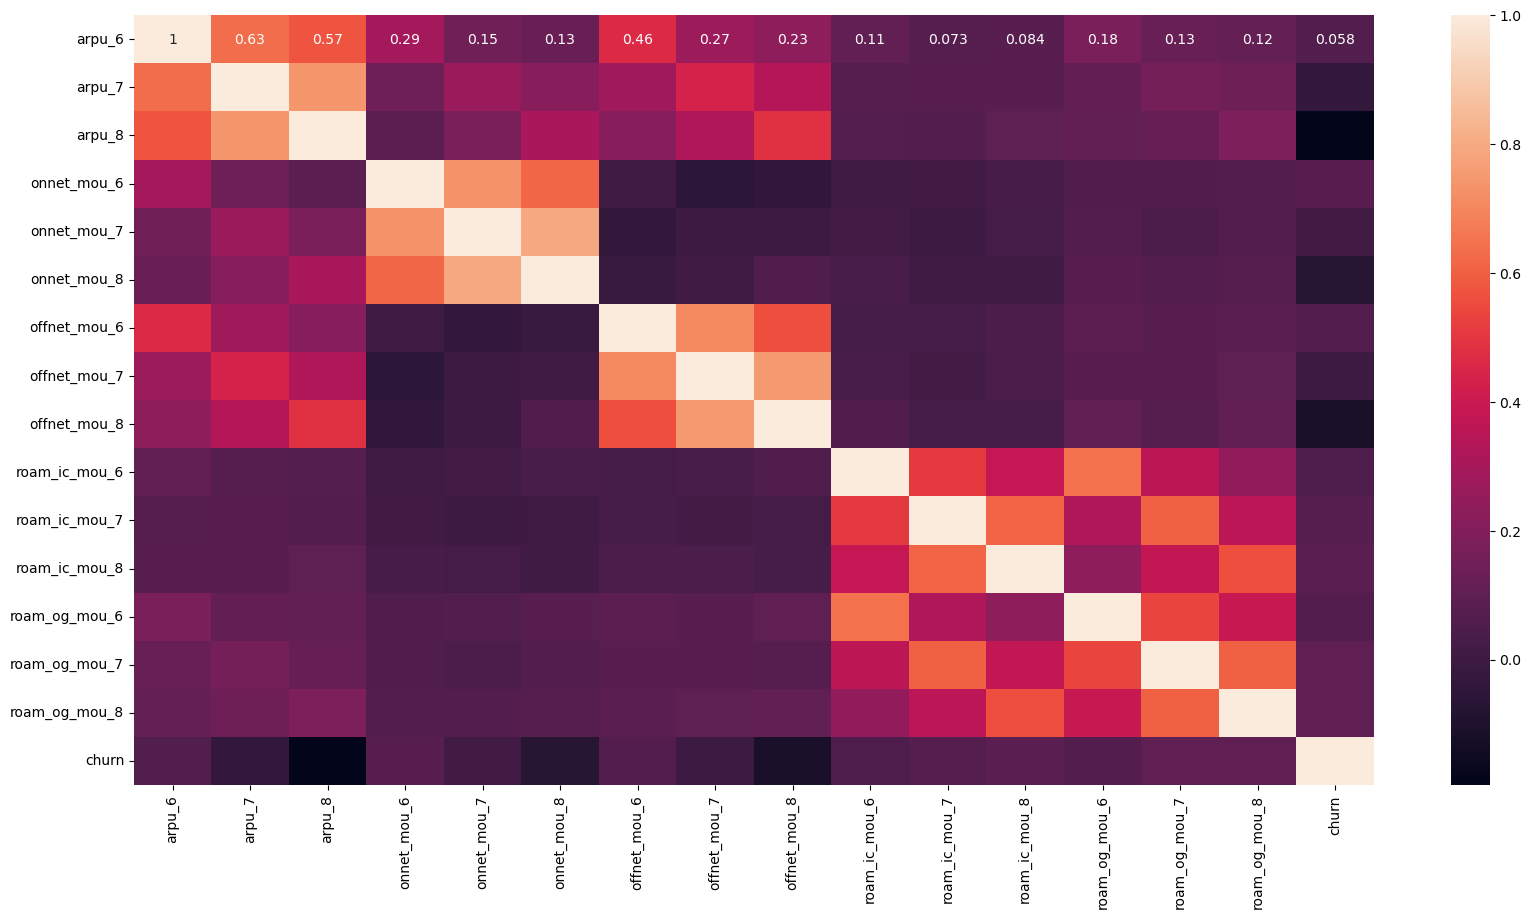

In [43]:
roam_cols = [col for col in data_high_val_cust.columns if 'roam_' in col or'arpu_' in col or'onnet_' in col or 'offnet_' in col]
roam_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[roam_cols].corr(), annot=True)
plt.show()

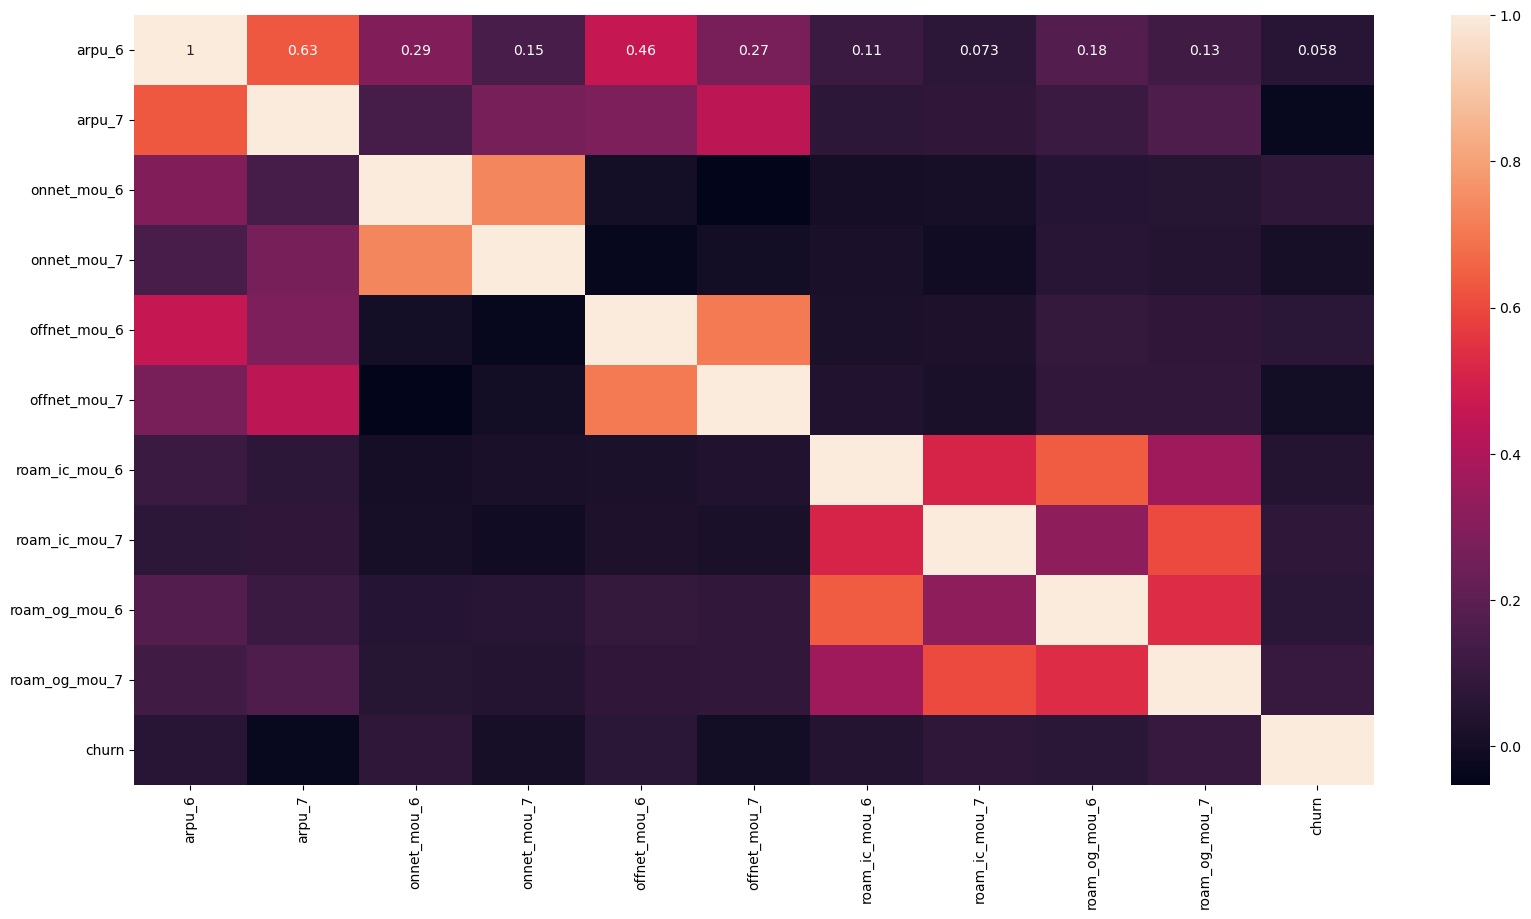

In [44]:
roam_cols = [col for col in data_high_val_cust.columns if ('roam_' in col or'arpu_' in col or'onnet_' in col or 'offnet_' in col)and '_8' not in col]
roam_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[roam_cols].corr(), annot=True)
plt.show()

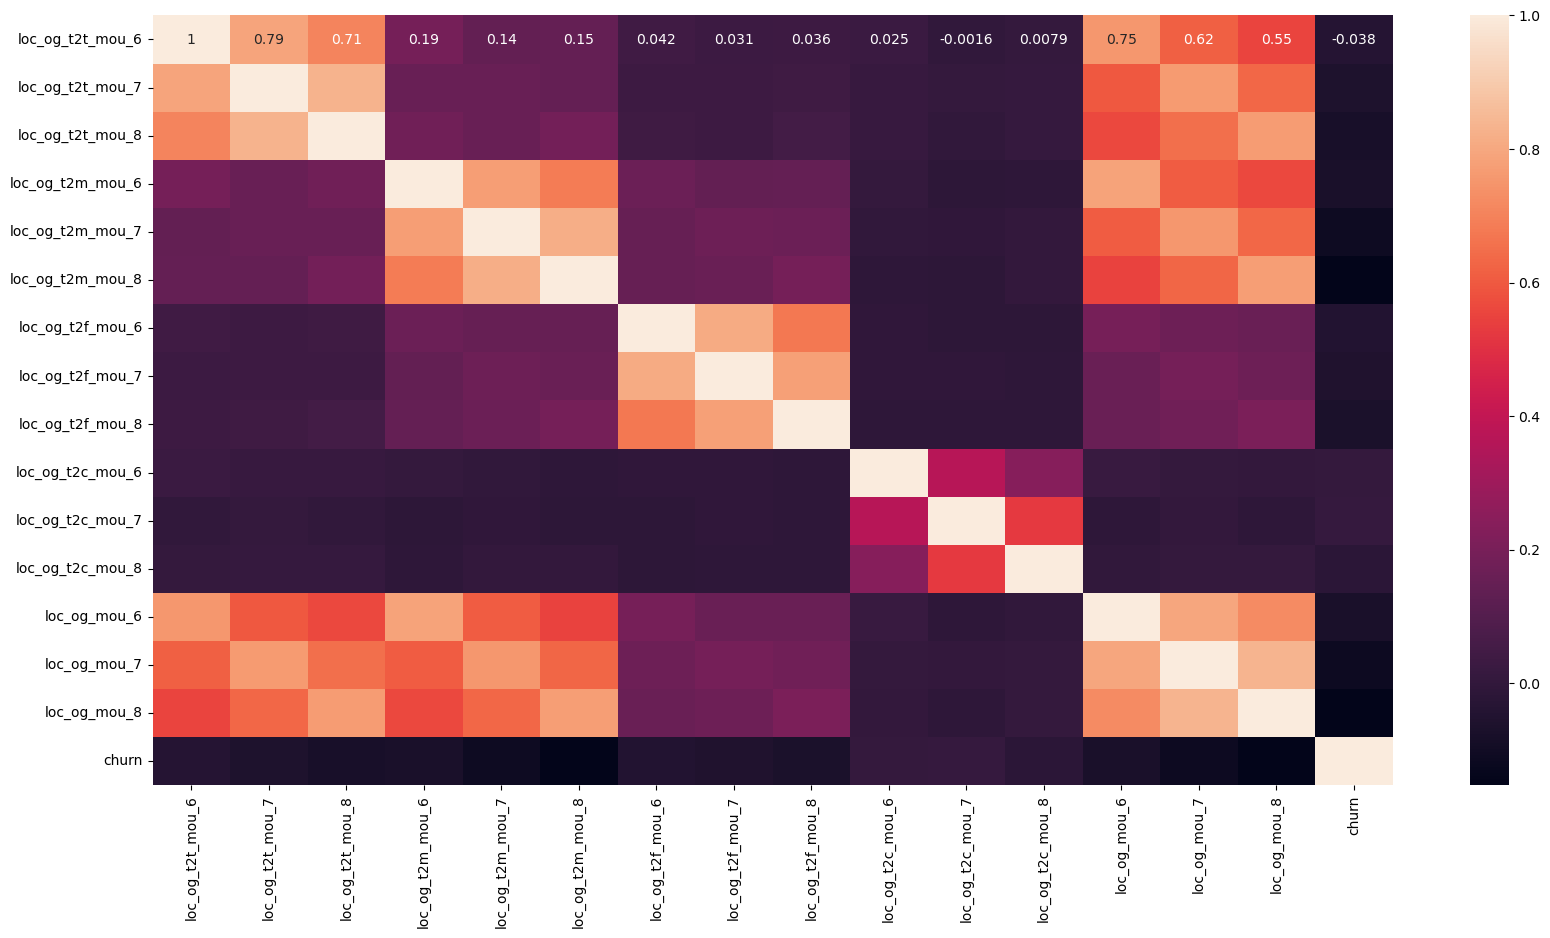

In [45]:
loc_og_cols = [col for col in data_high_val_cust.columns if 'loc_og_' in col]
loc_og_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[loc_og_cols].corr(), annot=True)
plt.show()

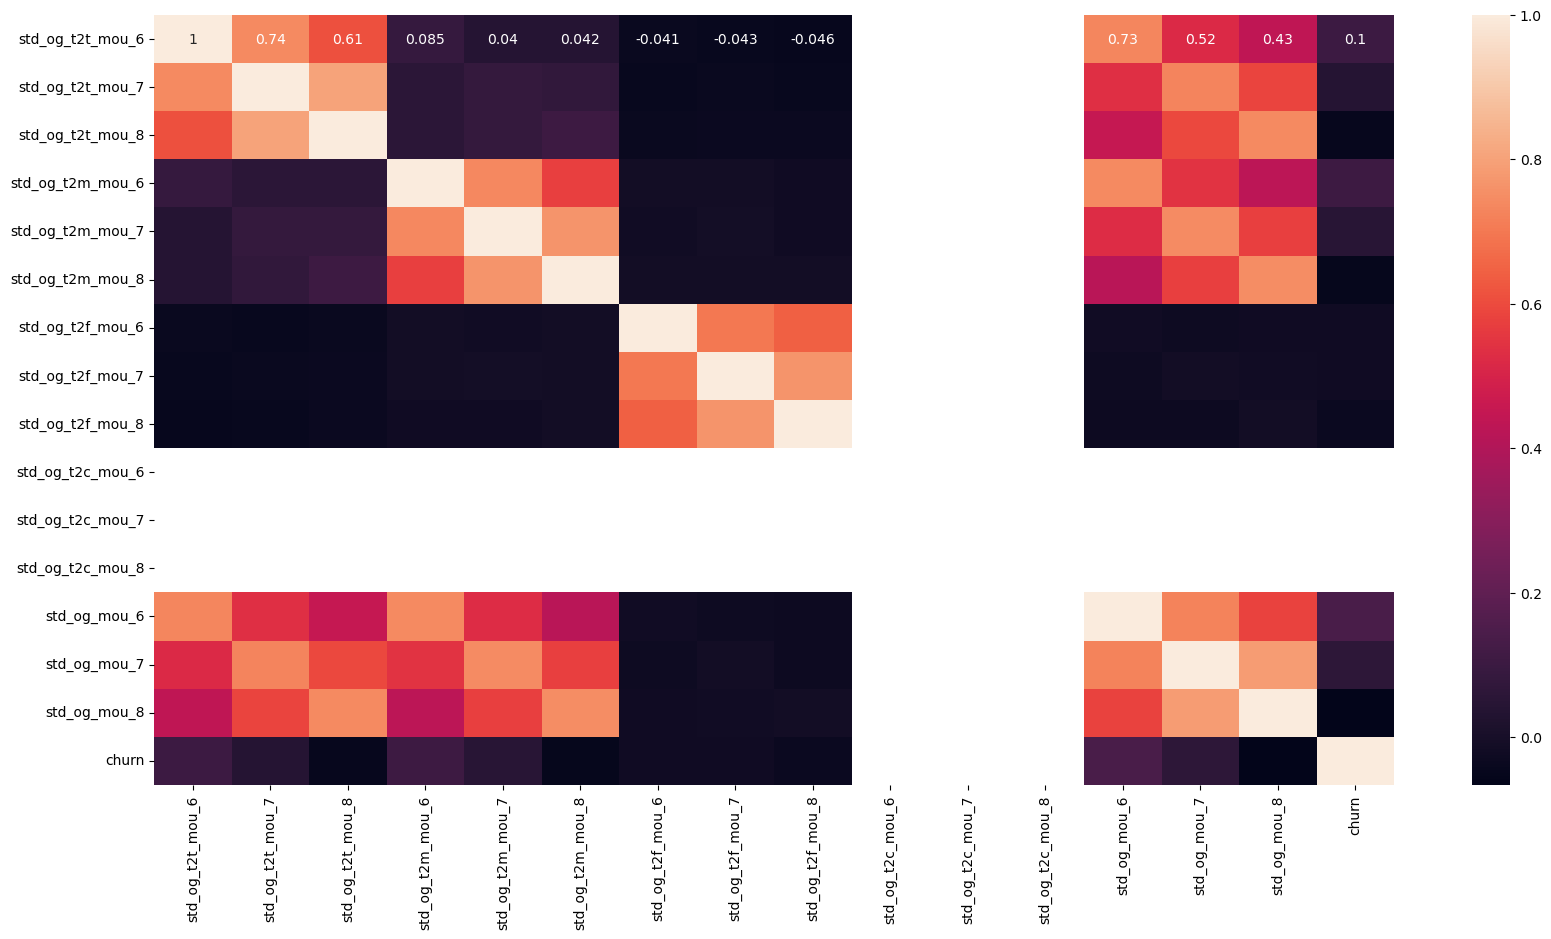

In [46]:
std_og_cols = [col for col in data_high_val_cust.columns if 'std_og_' in col]
std_og_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[std_og_cols].corr(), annot=True)
plt.show()

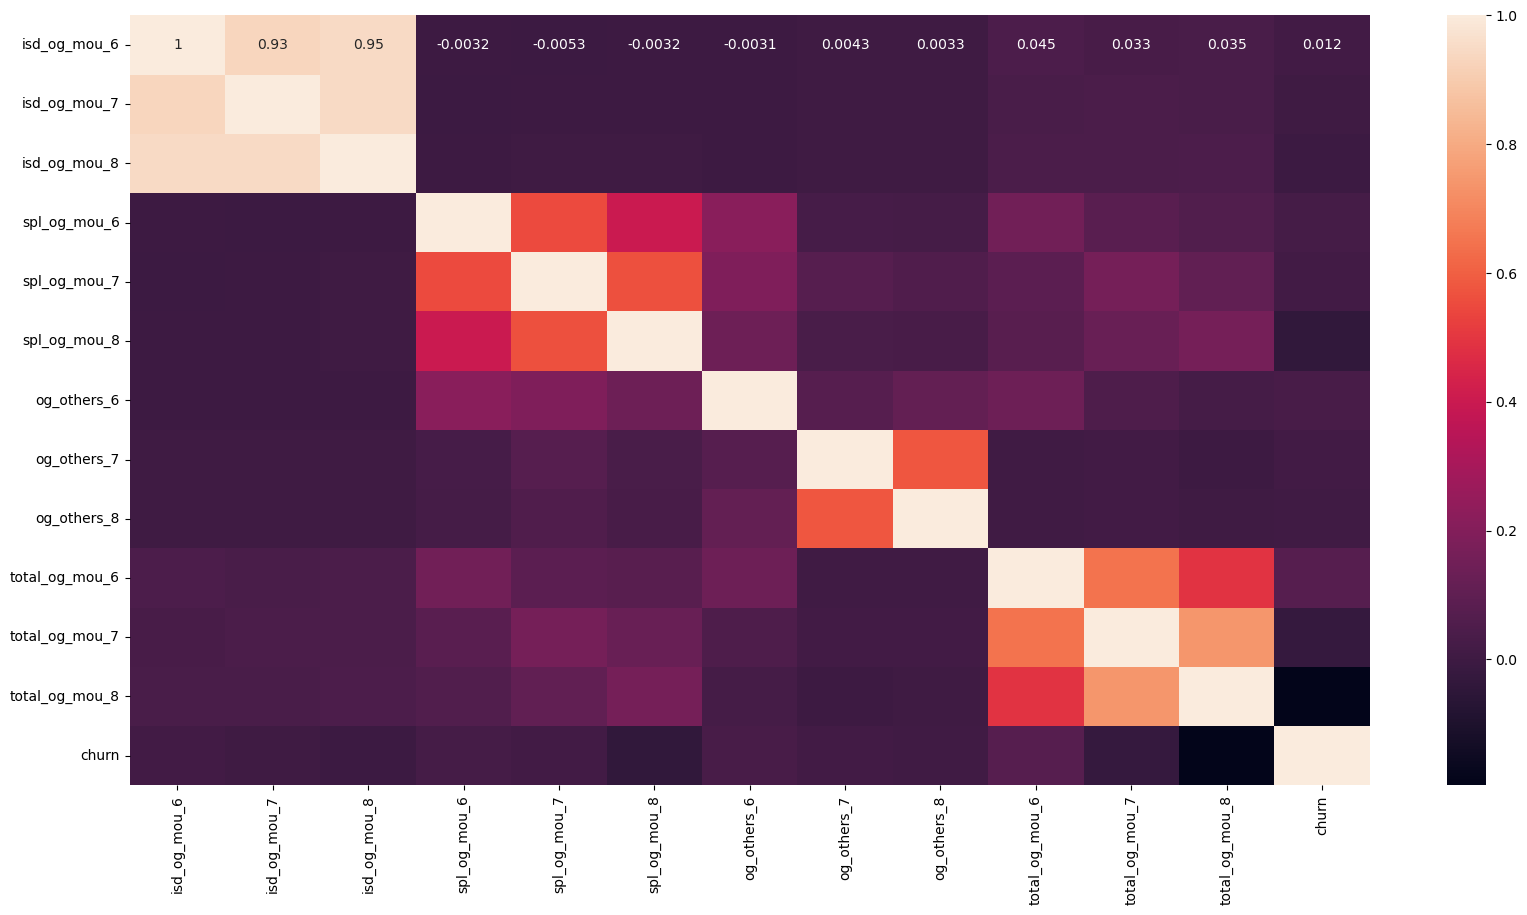

In [47]:
isd_spl_og_cols = [col for col in data_high_val_cust.columns if 'isd_og_' in col or 'spl_og_' in col or 'og_others_' in col or 'total_og_' in col]
isd_spl_og_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[isd_spl_og_cols].corr(), annot=True)
plt.show()

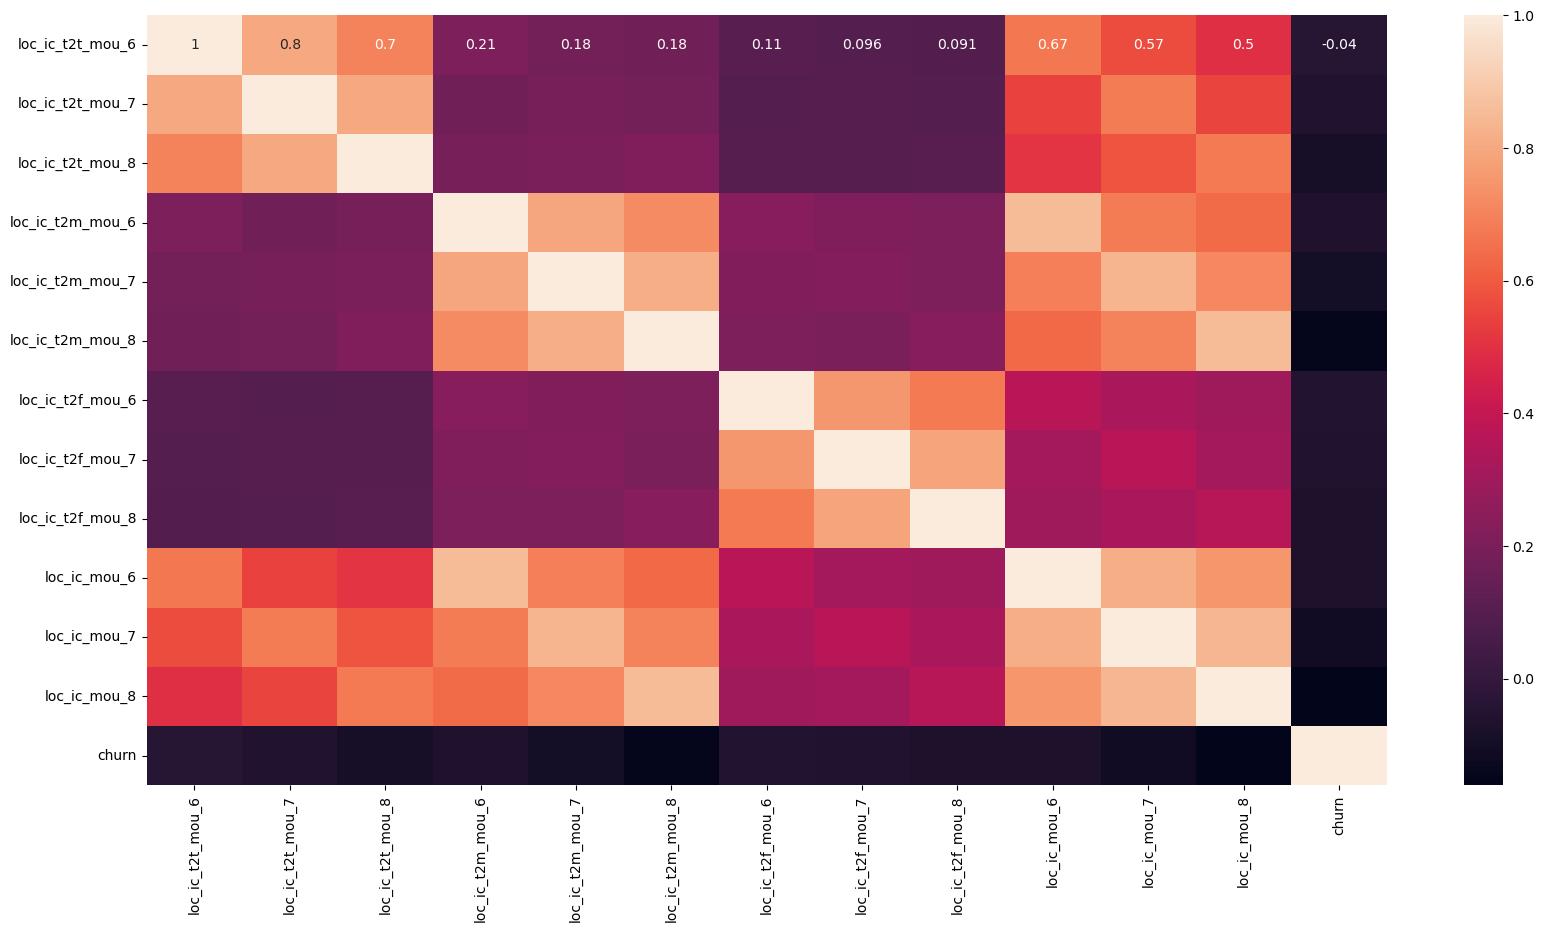

In [48]:
loc_ic_cols = [col for col in data_high_val_cust.columns if 'loc_ic_' in col]
loc_ic_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[loc_ic_cols].corr(), annot=True)
plt.show()

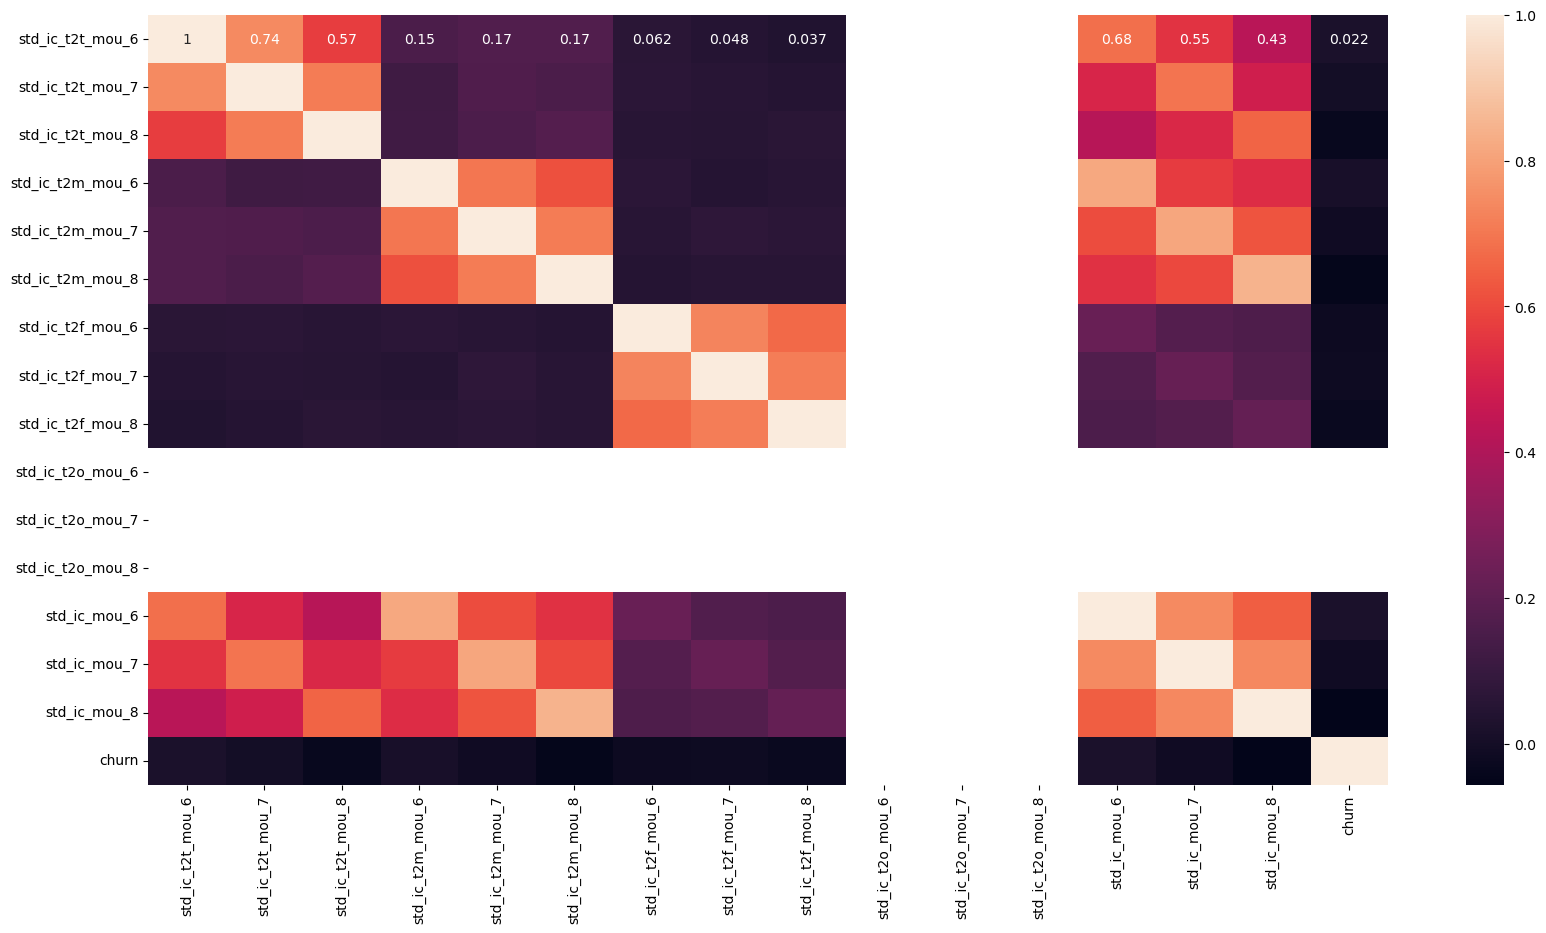

In [49]:
std_ic_cols = [col for col in data_high_val_cust.columns if 'std_ic_' in col]
std_ic_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[std_ic_cols].corr(), annot=True)
plt.show()

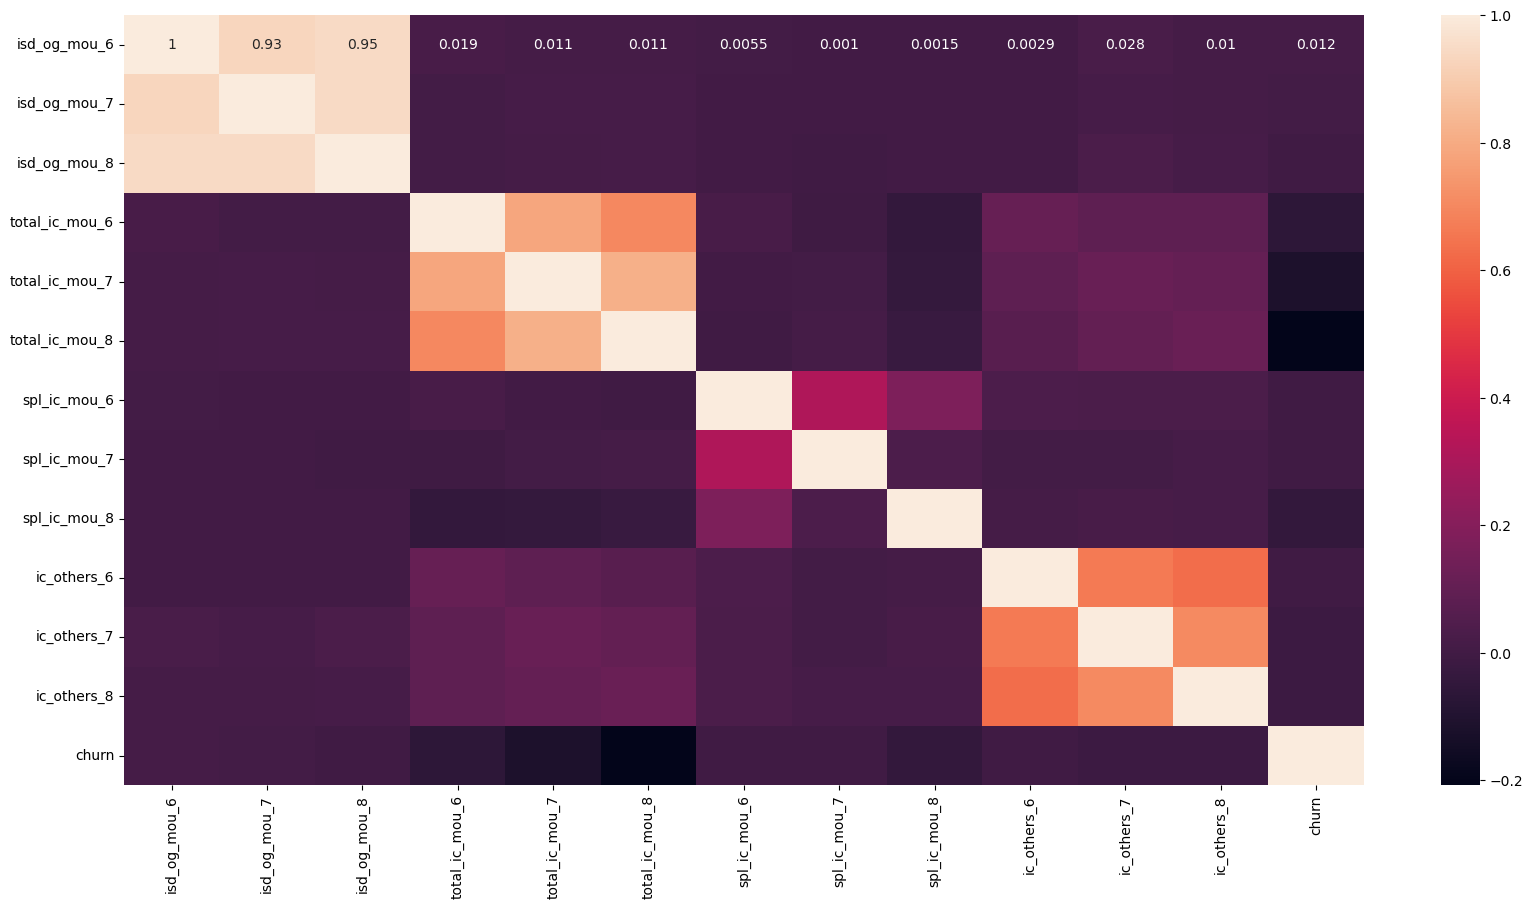

In [50]:
tot_spl_isd_ic_cols = [col for col in data_high_val_cust.columns if 'total_ic_' in col or 'spl_ic_' in col or 'ic_others_' in col or 'isd_og_' in col]
tot_spl_isd_ic_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[tot_spl_isd_ic_cols].corr(), annot=True)
plt.show()

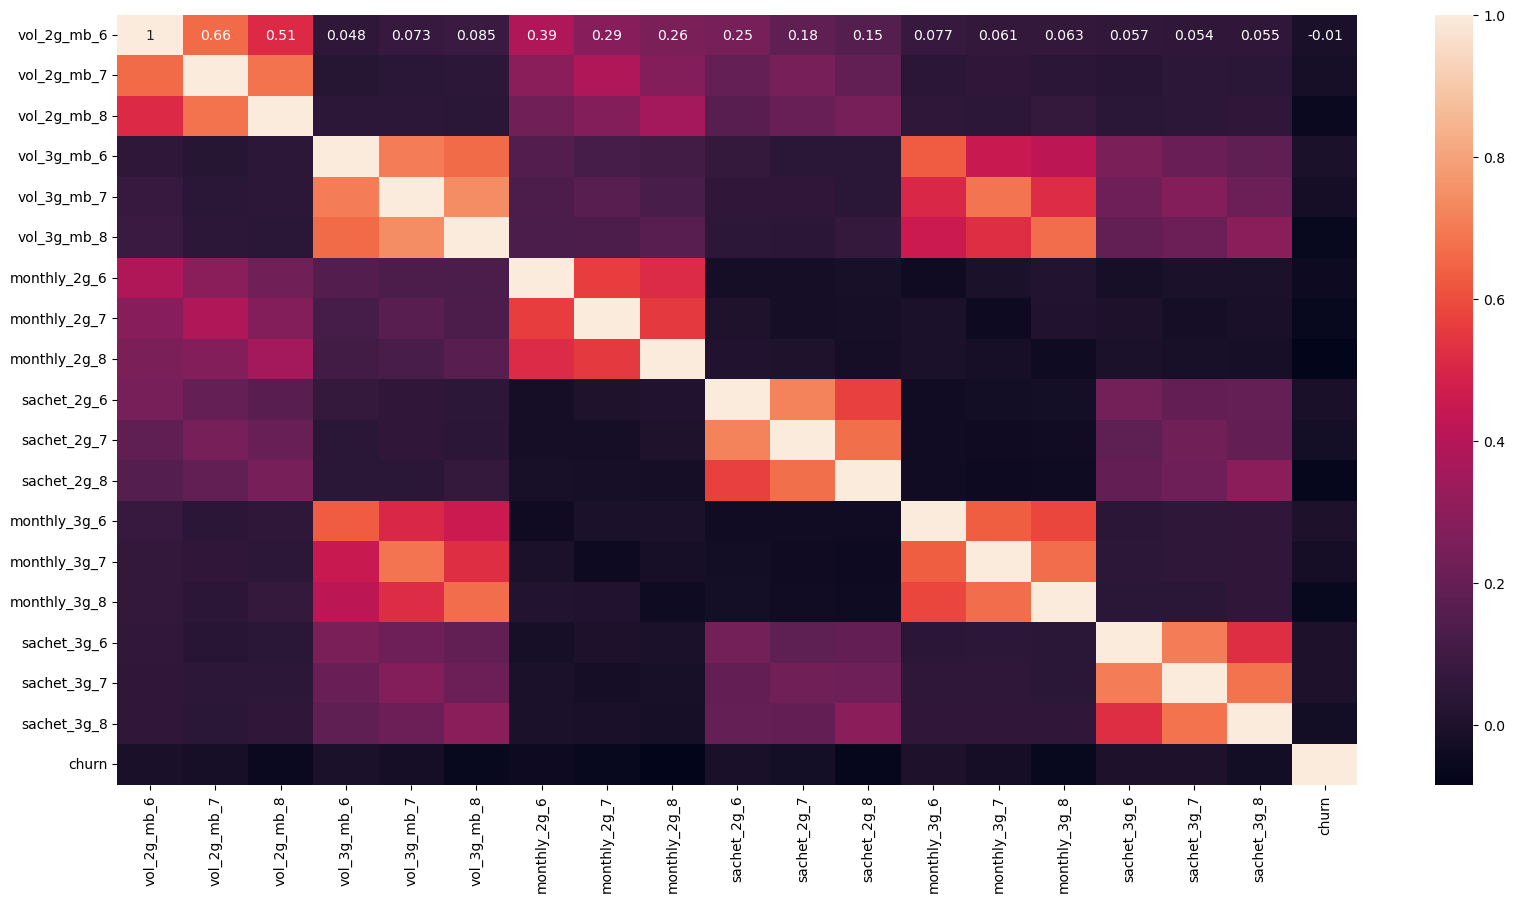

In [51]:
vol_mon_sac_cols = [col for col in data_high_val_cust.columns if 'vol_' in col or 'monthly_' in col or 'sachet_' in col]
vol_mon_sac_cols.append('churn')
plt.figure(figsize=(20,10))
sns.heatmap(data_high_val_cust[vol_mon_sac_cols].corr(), annot=True)
plt.show()

# Dropping NAN values for now, this needs to be worked upon as per outlier analysis

In [52]:
data_high_val_cust = data_high_val_cust.dropna()

In [53]:
X = data_high_val_cust.drop('churn', axis = 1)
y = data_high_val_cust['churn']

In [54]:
X.shape , y.shape

((28487, 134), (28487,))

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [56]:
logreg = LogisticRegression()

# First Model

In [57]:
X_train_sm=sm.add_constant(X_train,has_constant="add")
X_test_sm=sm.add_constant(X_test,has_constant="add")

In [58]:
model1=sm.GLM(np.array(y_train),X_train_sm,family=sm.families.Binomial())
# Binomial --> Binary Classification
result1=model1.fit()
result1.summary()
#Generalised Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19940
Model:                            GLM   Df Residuals:                    19812
Model Family:                Binomial   Df Model:                          127
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3611.3
Date:                Sat, 06 Jul 2024   Deviance:                       7222.6
Time:                        01:28:10   Pearson chi2:                 3.09e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1584
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.9021      0.354      8.197      0.000       2.208       3.596
arpu_6               7.216e-05      0.000      0.202      0.840      -0.001       0.001
arpu_7               7.934e-06      0.000      0.022      0.982      -0.001       0.001
arpu_8                  0.0005      0.000      1.222      0.222      -0.000       0.001
onnet_mou_6            -0.0063      0.007     -0.908      0.364      -0.020       0.007
onnet_mou_7            -0.0008      0.004     -0.206      0.837      -0.009       0.007
onnet_mou_8             0.0004      0.004      0.104      0.917      -0.007       0.007
offnet_mou_6           -0.0071      0.007     -1.034      0.301      -0.021       0.006
offnet_mou_7         3.728e-05      0.004      0.009      0.992      -0.008       0.008
offnet_mou_8           -0.0009      0.003     -0.257      0.798      -0.008       0.006
roam_ic_mou_6           0.0001      0.000      0.328      0.743      -0.001       0.001
roam_ic_mou_7           0.0012      0.001      2.202      0.028       0.000       0.002
roam_ic_mou_8          -0.0003      0.000     -0.621      0.535      -0.001       0.001
roam_og_mou_6           0.0068      0.007      0.986      0.324      -0.007       0.020
roam_og_mou_7           0.0021      0.004      0.528      0.597      -0.006       0.010
roam_og_mou_8           0.0005      0.004      0.131      0.896      -0.006       0.007
loc_og_t2t_mou_6       11.0936      5.786      1.917      0.055      -0.246      22.433
loc_og_t2t_mou_7        6.1420      5.761      1.066      0.286      -5.149      17.432
loc_og_t2t_mou_8       32.5712      6.232      5.227      0.000      20.357      44.785
loc_og_t2m_mou_6       11.0939      5.786      1.917      0.055      -0.246      22.434
loc_og_t2m_mou_7        6.1409      5.761      1.066      0.286      -5.150      17.431
loc_og_t2m_mou_8       32.5724      6.232      5.227      0.000      20.359      44.786
loc_og_t2f_mou_6       11.0965      5.786      1.918      0.055      -0.244      22.437
loc_og_t2f_mou_7        6.1381      5.761      1.065      0.287      -5.153      17.429
loc_og_t2f_mou_8       32.5723      6.232      5.227      0.000      20.358      44.787
loc_og_t2c_mou_6        0.0002      0.005      0.042      0.967      -0.009       0.009
loc_og_t2c_mou_7       -0.0029      0.004     -0.685      0.493      -0.011       0.005
loc_og_t2c_mou_8        0.0060      0.006      1.085      0.278      -0.005       0.017
loc_og_mou_6          -16.4576      7.033     -2.340      0.019     -30.241      -2.674
loc_og_mou_7          -11.1022      7.428     -1.495      0.135     -25.661       3.457
loc_og_mou_8           -9.2480      8.041     -1.150      0.250     -25.008       6.512
std_og_t2t_mou_6       -1.7915      6.709     -0.267      0.789     -14.941      11.358
std

### As we see from above results, the log likelihood is nan, which means the model fit is poor. We need to handle outliers, multicollinearity and scaling of features


### Getting parameters from RFE 

In [59]:
rfe = RFE(estimator=logreg, n_features_to_select=100)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=100)

In [60]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', True, 1),
 ('arpu_8', False, 10),
 ('onnet_mou_6', False, 9),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 13),
 ('roam_ic_mou_7', True, 1),
 ('roam_ic_mou_8', False, 26),
 ('roam_og_mou_6', True, 1),
 ('roam_og_mou_7', True, 1),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 6),
 ('loc_og_t2t_mou_7', False, 7),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', False, 11),
 ('loc_og_t2m_mou_7', True, 1),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', True, 1),
 ('loc_og_t2f_mou_7', False, 20),
 ('loc_og_t2f_mou_8', True, 1),
 ('loc_og_t2c_mou_6', False, 4),
 ('loc_og_t2c_mou_7', True, 1),
 ('loc_og_t2c_mou_8', False, 23),
 ('loc_og_mou_6', True, 1),
 ('loc_og_mou_7', True, 1),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 14),
 ('std_og_t2t_mou_7', True, 1),
 ('std_og_t2t_mou_8', True, 1),
 ('std_og_t2m

In [61]:
X_train.columns[rfe.support_]

Index(['arpu_6', 'arpu_7', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_7', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_6', 'isd_og_mou_7',
       'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'total_og_mou_7', 'total_og_mou_8',
       'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6',
       'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'loc_ic_mou_8', 

In [62]:
col_rfe_support = X_train.columns[rfe.support_]

In [63]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train[col_rfe_support])), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19940
Model:                            GLM   Df Residuals:                    19839
Model Family:                Binomial   Df Model:                          100
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3629.1
Date:                Sat, 06 Jul 2024   Deviance:                       7258.2
Time:                        01:28:34   Pearson chi2:                 4.56e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1569
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.8824      0.343      8.413      0.000       2.211       3.554
arpu_6                 0.0001      0.000      0.302      0.763      -0.001       0.001
arpu_7             -7.431e-05      0.000     -0.219      0.827      -0.001       0.001
onnet_mou_7           -0.0029      0.004     -0.783      0.434      -0.010       0.004
onnet_mou_8            0.0016      0.003      0.479      0.632      -0.005       0.008
offnet_mou_6          -0.0006      0.000     -1.537      0.124      -0.001       0.000
offnet_mou_7          -0.0023      0.004     -0.645      0.519      -0.009       0.005
offnet_mou_8           0.0004      0.003      0.108      0.914      -0.006       0.007
roam_ic_mou_7          0.0011      0.000      3.175      0.001       0.000       0.002
roam_og_mou_6          0.0005      0.000      1.331      0.183      -0.000       0.001
roam_og_mou_7          0.0044      0.004      1.183      0.237      -0.003       0.012
roam_og_mou_8         -0.0008      0.003     -0.227      0.821      -0.007       0.006
loc_og_t2t_mou_8      35.6168      6.089      5.849      0.000      23.682      47.551
loc_og_t2m_mou_7      -0.0007      0.001     -0.743      0.457      -0.003       0.001
loc_og_t2m_mou_8      35.6180      6.089      5.849      0.000      23.684      47.553
loc_og_t2f_mou_6       0.0001      0.003      0.046      0.963      -0.005       0.005
loc_og_t2f_mou_8      35.6162      6.089      5.849      0.000      23.681      47.551
loc_og_t2c_mou_7      -0.0004      0.003     -0.132      0.895      -0.007       0.006
loc_og_mou_6           0.0003      0.000      1.163      0.245      -0.000       0.001
loc_og_mou_7          -0.0011      0.002     -0.488      0.626      -0.005       0.003
loc_og_mou_8         -14.8514      7.490     -1.983      0.047     -29.532      -0.171
std_og_t2t_mou_7     -11.2522      6.616     -1.701      0.089     -24.219       1.715
std_og_t2t_mou_8      20.7664      4.532      4.582      0.000      11.884      29.648
std_og_t2m_mou_6       0.0004      0.000      0.905      0.365      -0.000       0.001
std_og_t2m_mou_7     -11.2523      6.616     -1.701      0.089     -24.219       1.715
std_og_t2m_mou_8      20.7674      4.532      4.583      0.000      11.885      29.649
std_og_t2f_mou_6       0.0032      0.003      0.965      0.335      -0.003       0.010
std_og_t2f_mou_7     -11.2626      6.616     -1.702      0.089     -24.231       1.706
std_og_t2f_mou_8      20.7642      4.532      4.581      0.000      11.881      29.647
std_og_mou_6           0.0003      0.000      2.303      0.021    4.29e-05       0.001
std_og_mou_7          11.2508      6.616      1.701      0.089      -1.716      24.218
isd_og_mou_6          -0.0016      0.003     -0.554      0.580      -0.007       0.004
isd_og_mou_7           0.0051      0.0

## As its hard to guess on the number of features to be used for RFE model, implementing RFECV to get a better understanding on the number of features which can give a maximum performance on logistic regression model.

In [64]:
rfecv = RFECV(estimator = logreg, cv = 4)
rfecv.fit(X_train, y_train)

RFECV(cv=4, estimator=LogisticRegression())

In [65]:
rfecv.n_features_

64

In [66]:
rfecv.support_

array([False,  True, False, False, False,  True, False,  True,  True,
       False,  True, False,  True,  True,  True, False, False, False,
       False,  True, False, False, False,  True, False,  True, False,
        True,  True,  True, False, False, False, False, False,  True,
       False,  True,  True, False, False, False,  True,  True, False,
       False, False,  True, False, False,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True, False, False,  True, False, False, False,
        True,  True,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False,  True, False, False,  True,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,

In [67]:
col_rfecv_support = X_train.columns[rfecv.support_]

### Fitting the model again with rfecv identified features

In [68]:
logm2 = sm.GLM(y_train,(sm.add_constant(X_train[col_rfecv_support])), family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19940
Model:                            GLM   Df Residuals:                    19875
Model Family:                Binomial   Df Model:                           64
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3765.9
Date:                Sat, 06 Jul 2024   Deviance:                       7531.8
Time:                        01:32:23   Pearson chi2:                 2.57e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1452
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5924      0.320      8.096      0.000       1.965       3.220
arpu_7                 0.0002      0.000      1.540      0.124   -6.74e-05       0.001
onnet_mou_8           -0.0002      0.003     -0.091      0.927      -0.005       0.005
offnet_mou_7           0.0002      0.000      1.179      0.239      -0.000       0.000
offnet_mou_8          -0.0014      0.003     -0.543      0.587      -0.007       0.004
roam_ic_mou_7          0.0012      0.000      3.398      0.001       0.001       0.002
roam_og_mou_6          0.0003      0.000      1.329      0.184      -0.000       0.001
roam_og_mou_7          0.0013      0.000      3.300      0.001       0.001       0.002
roam_og_mou_8          0.0016      0.003      0.585      0.558      -0.004       0.007
loc_og_t2m_mou_7      -0.0005      0.000     -1.226      0.220      -0.001       0.000
loc_og_t2f_mou_8      -0.0062      0.004     -1.396      0.163      -0.015       0.002
loc_og_t2c_mou_7      -0.0012      0.003     -0.372      0.710      -0.007       0.005
loc_og_mou_6           0.0002      0.000      0.996      0.319      -0.000       0.001
loc_og_mou_7          -0.0027      0.002     -1.711      0.087      -0.006       0.000
loc_og_mou_8          -0.0005      0.000     -1.168      0.243      -0.001       0.000
std_og_t2m_mou_8       0.0010      0.001      1.919      0.055    -2.1e-05       0.002
std_og_t2f_mou_7      -0.0093      0.006     -1.630      0.103      -0.021       0.002
std_og_t2f_mou_8      -0.0055      0.009     -0.607      0.544      -0.023       0.012
std_og_mou_6           0.0003   6.52e-05      5.262      0.000       0.000       0.000
std_og_mou_7          -0.0029      0.002     -1.845      0.065      -0.006       0.000
isd_og_mou_8           0.0018      0.002      0.760      0.447      -0.003       0.006
spl_og_mou_8          -0.0020      0.002     -0.828      0.407      -0.007       0.003
og_others_6           -0.0199      0.014     -1.419      0.156      -0.047       0.008
og_others_7           -0.0053      0.014     -0.382      0.702      -0.033       0.022
og_others_8            0.0141      0.015      0.961      0.336      -0.015       0.043
total_og_mou_7         0.0031      0.002      1.951      0.051   -1.42e-05       0.006
total_og_mou_8        -0.0005      0.003     -0.188      0.851      -0.006       0.005
loc_ic_t2t_mou_6      11.9701      5.137      2.330      0.020       1.901      22.039
loc_ic_t2t_mou_8      48.7788      5.528      8.825      0.000      37.945      59.613
loc_ic_t2m_mou_6      11.9701      5.137      2.330      0.020       1.901      22.039
loc_ic_t2m_mou_7       0.0009      0.001      1.497      0.134      -0.000       0.002
loc_ic_t2m_mou_8      48.7788      5.528      8.825      0.000      37.945      59.613
loc_ic_t2f_mou_6      11.9667      5.1

In [69]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col_rfecv_support].columns
vif['VIF'] = [variance_inflation_factor(X_train[col_rfecv_support].values, i) for i in range(X_train[col_rfecv_support].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
33,loc_ic_mou_6,4.305195e+09
35,loc_ic_mou_8,4.209906e+09
28,loc_ic_t2m_mou_6,2.078488e+09
30,loc_ic_t2m_mou_8,2.052487e+09
44,std_ic_mou_8,8.370227e+08
...,...,...
9,loc_og_t2f_mou_8,1.440000e+00
10,loc_og_t2c_mou_7,1.380000e+00
60,aug_vbc_3g,1.340000e+00
21,og_others_6,1.290000e+00
